<a href="https://colab.research.google.com/github/Gratisfo/project_ml/blob/main/%D0%A1%D0%BD%D0%B8%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5_%D1%80%D0%B0%D0%B7%D0%BC%D0%B5%D1%80%D0%BD%D0%BE%D1%81%D1%82%D0%B5%D0%B9_%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%D0%B0_%D1%84%D0%B0%D0%BD%D1%84%D0%B8%D0%BA%D0%BE%D0%B2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Задача о снижениии размерностей**


In [ ]:
from razdel import tokenize
from pymorphy2 import MorphAnalyzer
import nltk
import string
from nltk.corpus import stopwords
from string import ascii_letters

In [ ]:
# функция для препоцессинга

morph = MorphAnalyzer()

def preproc(doc):
    with open(doc, encoding='utf-8') as f:
        text = f.read()
    
    # токенизируем
    tokens = [_.text for _ in list(tokenize(text))]
    
    # приводим к нижнему регистру
    tokens = [w.lower() for w in tokens]
    
    # убираем пунктуацию
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    # убираем числа и оставлем только кирилицу
    words = [word for word in stripped if word.isalpha()
             and not all(map(lambda c: c in ascii_letters, word))]
    
    # удаляем стоп-слова
    stop_words = set(stopwords.words('russian'))
    words = [w for w in words if not w in stop_words]
    
    text = ' '.join(words)
    return text
    

In [ ]:
# подготавливаем данные для корпуса
def get_data(dir_names):
    preproc_texts = []
    topic = []
    
    for dir_name in dir_names:
        files = [f for f in os.listdir(os.path.abspath(dir_name))]
        for file in files:
            l = os.path.abspath(file)
            text = preproc(os.path.abspath(dir_name) + '\\' + file)
            preproc_texts.append(text)
            if dir_name == 'Фанфик2':
                dir_name = 'Фанфик'   
            topic.append(dir_name)
    return preproc_texts, topic
            
dir_names = ['Хоррор', 'Эзотерика', 'Фанфик2', 'Фанфик']
preproc_texts, = get_data(dir_names)

In [ ]:
import pandas as pd
df = pd.DataFrame(columns = ['Текст', 'Жанр'])
df['Текст'] = preproc_texts
df['Жанр'] = topic

In [ ]:
# получаем мактрицу векторов для текстов с помощью tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(analyzer = str.split, max_df=0.98, min_df=5, max_features=25000)
data = vectorizer.fit_transform(df['Текст'])

In [ ]:
# высчитываем рса
from sklearn.decomposition import PCA

components = PCA(n_components=2).fit_transform(data.todense())
pca_df = pd.DataFrame(data = components, columns = ['component1', 'component2'])
pca_final = pd.concat([pca_df, df[['Жанр']]], axis = 1)

In [ ]:
# высчитываем tsne
from sklearn.manifold import TSNE

tsne = TSNE().fit_transform(PCA(n_components=50).fit_transform(data.todense()))
tsne_df = pd.DataFrame(data = tsne, columns = ['component1', 'component2'])
tsne_final = pd.concat([tsne_df, df[['Жанр']]], axis = 1)

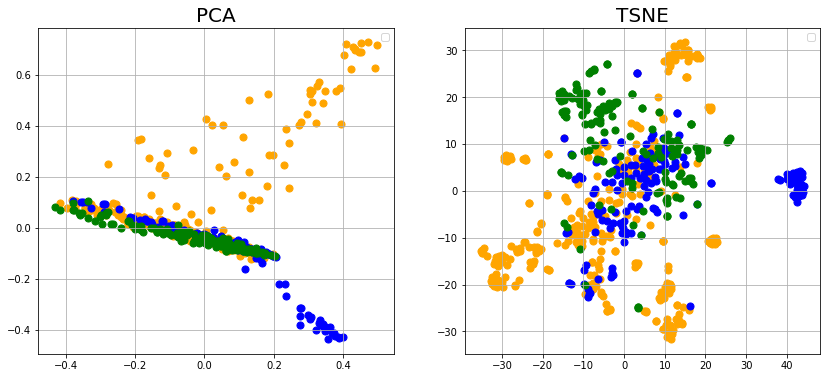

In [ ]:
# визуализируем
import matplotlib.pyplot as plt
import matplotlib.cm as cm

f, ax = plt.subplots(1, 2, figsize=(14, 6))
targets = ['Фанфик', 'Хоррор', 'Эзотерика']
colors = ['orange', 'blue', 'green']

ax[0].set_title('PCA', fontsize = 20)
ax[0].legend(targets)
for target, color in zip(targets,colors):
    indicesToKeep = pca_final['Жанр'] == target
    ax[0].scatter(pca_final.loc[indicesToKeep, 'component1']
               , pca_final.loc[indicesToKeep, 'component2']
               , c = color
               , s = 50)

ax[1].set_title('TSNE', fontsize = 20)
ax[1].legend(targets)
for target, color in zip(targets,colors):
    indicesToKeep = tsne_final['Жанр'] == target
    ax[1].scatter(tsne_final.loc[indicesToKeep, 'component1']
               , tsne_final.loc[indicesToKeep, 'component2']
               , c = color
               , s = 50)

ax[0].grid()
ax[1].grid()